In [2]:
import numpy as np
from scipy import misc
from matplotlib import colors
from bokeh.plotting import figure, ColumnDataSource

In [3]:
from bokeh import models
from bokeh.io import push_notebook, show, output_notebook
import ipywidgets as widgets
from IPython.display import display

import matplotlib.pyplot as plt

import colorsys

In [34]:
def customquant(hsv, boundaries):
    '''Where hsv is a numpy array and boundaries is a list of points 
    within the range of hsv.
    
    Returns array same shape as hsv, with all points binned according to boundaries.
    The bin values are equally spaced along the range of hsv'''
    condlist = [hsv < bound for bound in boundaries]
    choicelist = [(boundaries[i - 1] + x) / 2 for i, x in enumerate(boundaries)] #np.linspace(0, 1, num=len(boundaries))
    return np.select(condlist, choicelist, default=1)

def forcehex_to2dig(num):
    '''Converts an integer, num to hex value.
    If the hex value is one digit, adds a zero in front
    returns a string with no 0x prefix'''
    firsttry = hex(num).split('x')[1]
    if len(firsttry) == 1:
        return '0' + firsttry
    return firsttry

def hue2hexrgb(hue):
    '''Converts a hsv hue (ranged zero to one) into a rgb hex string #RRGGBB
    with full saturation and brightness'''
    rgb = [int(coordinate * 255) for 
           coordinate in 
           colorsys.hsv_to_rgb(hue, 1, 1)]
    return '#' + forcehex_to2dig(rgb[0]) + forcehex_to2dig(rgb[1]) + forcehex_to2dig(rgb[2])



In [5]:
%matplotlib notebook
output_notebook()

Loading BokehJS ...

In [37]:
filelist = ['r1c1_08_ocmap.png', 'r1c2_15_ocmap.png', 'r1c3_20_ocmap.png']

ocmap_dict_list = []

for file in filelist:
    ocmap = misc.imread(file).astype(np.int)
    ocmap_hsv = colors.rgb_to_hsv(ocmap)
    ocmap_hsv[..., 2] = (ocmap_hsv[..., 2] / 255) ** 0.6
    orientation_histogram = np.histogram(ocmap_hsv[..., 0].flat, bins = 100)
    datasize = len(orientation_histogram[1])
    
    file_dict = {
        'ocmap': ocmap,
        'ocmap_hsv': ocmap_hsv,
        'hue_channel': np.array(ocmap_hsv[..., 0]),
        'orientation_histogram': orientation_histogram,
        'rainbow_hue': [hue2hexrgb(i / datasize) for i in range(datasize)]                            
    }
    
    ocmap_dict_list.append(file_dict)
    
'''ocmap = misc.imread('justimages/RAW/r1c1_07_ocmap.png').astype(np.int)
ocmap_hsv = colors.rgb_to_hsv(ocmap)
ocmap_hsv[..., 2] = (ocmap_hsv[..., 2] / 255) ** 0.8

hue_channel = np.array(ocmap_hsv[..., 0])

orientation_histogram = np.histogram(ocmap_hsv[..., 0].flat, bins = 100)
datasize = len(orientation_histogram[1])
rainbow_hue = [hue2hexrgb(i / datasize) for i in range(datasize)]'''

"ocmap = misc.imread('justimages/RAW/r1c1_07_ocmap.png').astype(np.int)\nocmap_hsv = colors.rgb_to_hsv(ocmap)\nocmap_hsv[..., 2] = (ocmap_hsv[..., 2] / 255) ** 0.8\n\nhue_channel = np.array(ocmap_hsv[..., 0])\n\norientation_histogram = np.histogram(ocmap_hsv[..., 0].flat, bins = 100)\ndatasize = len(orientation_histogram[1])\nrainbow_hue = [hue2hexrgb(i / datasize) for i in range(datasize)]"

<IPython.core.display.Javascript object>


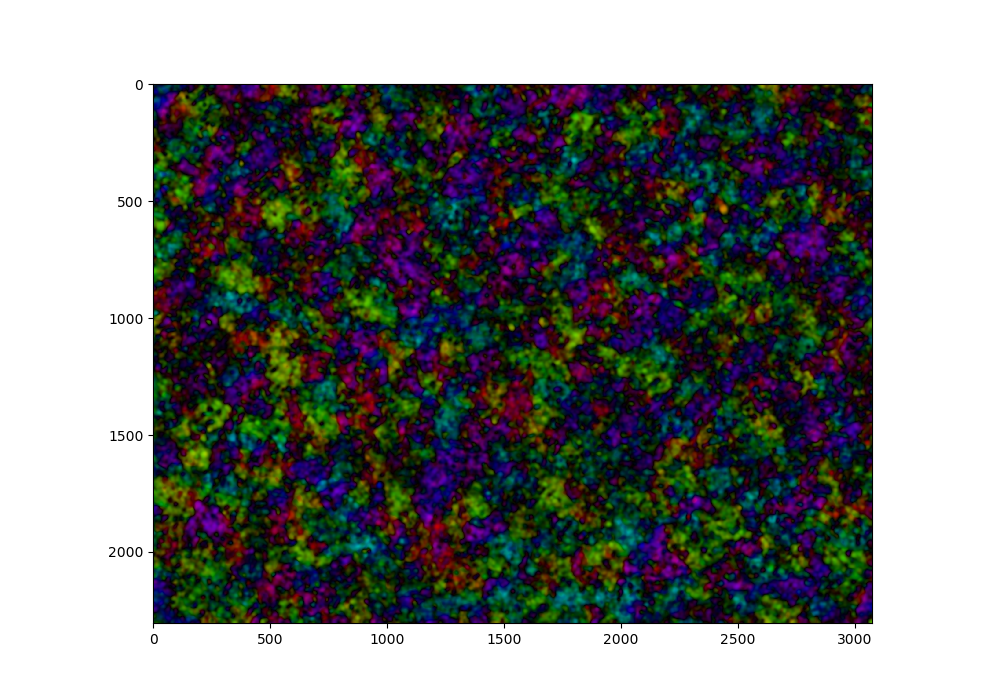

In [30]:
curr_file_dict = ocmap_dict_list[0]

#histogram
p = figure(tools='tap', width=700, height=200, 
           title='Orientation histogram', 
           x_axis_label='Direction (degrees)')

source = ColumnDataSource(
    data = dict(
        xvals = curr_file_dict['orientation_histogram'][1] * 180,
        yvals = curr_file_dict['orientation_histogram'][0],
        cvals = curr_file_dict['rainbow_hue']
    )
)


p.circle('xvals', 'yvals', color='cvals', source=source, size=10)

source.callback = models.CustomJS(args=dict(p=p), code="""
        var inds = cb_obj.get('selected')['1d'].indices;
        var d1 = cb_obj.get('data');
        console.log(d1)
        var kernel = IPython.notebook.kernel;
        IPython.notebook.kernel.execute("inds = " + inds);
        """
)

#callbacks
def on_button1_clicked(b):
    boundaries = sorted([source.data['xvals'][i] / 180 for i in inds])
    boundaries.insert(0, 0)
    boundaries.append(1)

    curr_file_dict['ocmap_hsv'][..., 0] = customquant(curr_file_dict['hue_channel'], boundaries)
    ocmap_customquant = colors.hsv_to_rgb(curr_file_dict['ocmap_hsv'])      
    
    wahh.set_data(ocmap_customquant)
    fig.canvas.draw()
    
    nue_hue_num = customquant(np.array(range(datasize)) / datasize, boundaries)
    nue_hue_hex = [hue2hexrgb(i) for i in nue_hue_num]
    source.data['cvals'] = nue_hue_hex
    push_notebook()

def on_button2_clicked(b):
    wahh.set_data(curr_file_dict['ocmap'] / 255)
    fig.canvas.draw()
    
    source.data['cvals'] = curr_file_dict['rainbow_hue']

    push_notebook()

def update(file):
    global curr_file_dict
    file_num = ['130sec', '1020sec', '2100sec'].index(file)
    curr_file_dict = ocmap_dict_list[file_num]
    
    source.data['xvals'] = curr_file_dict['orientation_histogram'][1] * 180
    source.data['yvals'] = curr_file_dict['orientation_histogram'][0]
    on_button2_clicked('something')
    
#buttons
button1 = widgets.Button(description='Quantize')
button1.on_click(on_button1_clicked)
button2 = widgets.Button(description='Reset')
button2.on_click(on_button2_clicked)

#image
fig, ax = plt.subplots()
fig.set_size_inches(10, 7)
wahh = ax.imshow(curr_file_dict['ocmap'] / 255)

show(p, notebook_handle=True)

In [31]:
display(button1)
display(button2)
widgets.interact(update, file=['130sec', '1020sec', '2100sec'])

In [33]:
asdf = [1, 2, 3, 4]
[(asdf[i-1] + x) / 2 for i, x in enumerate(asdf)]
    

[2.5, 1.5, 2.5, 3.5]